In [1]:
from ultralytics import YOLO
import os
import cv2
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
IMAGES_DIR = r'./train_dataset/img'  # Путь к вашему датасету с изображениями
MASKS_DIR = r'./train_dataset/msk'  # Путь к вашему датасету с масками
OUTPUT_DIR = r'./datasets/train_data'  # Путь к выходной директории
TRAIN_SIZE = 0.8  # Процент обучающей выборки

In [3]:
os.makedirs(os.path.join(OUTPUT_DIR, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'labels/val'), exist_ok=True)

In [5]:
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(('.jpg', '.png'))]
mask_files = [f for f in os.listdir(MASKS_DIR) if f.endswith('.png')]
if len(image_files) != len(mask_files):
    print(len(image_files))
    print(len(mask_files))
    print("Количество изображений и масок не совпадает.")
    for mask in mask_files:
        if mask.replace(".png", ".jpg") not in image_files:
            print(mask)

In [6]:
train_images, val_images = train_test_split(image_files, train_size=TRAIN_SIZE, random_state=42)

In [23]:
def convert_mask_to_yolo(mask_path, out):
    # Открываем изображение
    image = cv2.imread(mask_path)

    if image is None:
        print(f"Не удалось открыть изображение: {mask_path}")
        return
    
    height, width = image.shape[:2]

    # Создаем маску для черного цвета
    black_mask = cv2.inRange(image, (0, 0, 0), (50, 50, 50))

    # Создаем новое изображение, где черный цвет остается, а остальные цвета становятся белыми
    new_image = np.ones_like(image) * 255  # Начинаем с белого изображения
    new_image[black_mask > 0] = [0, 0, 0]  # Заменяем черные пиксели

    # Преобразуем в градации серого для нахождения контуров
    gray_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    # Находим контуры
    contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Сохраняем контуры в текстовом формате
    output_file_name = os.path.splitext(os.path.basename(mask_path))[0] + '.txt'
    output_file_path = os.path.join(OUTPUT_DIR, out, output_file_name)

    with open(output_file_path, 'w') as f:
        for index, contour in enumerate(contours):
            # Получаем координаты всех точек контура
            contour_points = contour.reshape(-1, 2)
            # Нормализуем координаты
            normalized_points = [(x / width, y / height) for x, y in contour_points]
            points_str = ' '.join(f"{x:.3f} {y:.3f}" for x, y in normalized_points)
            f.write(f"0 {points_str}\n")

In [24]:
# Копирование изображений и масок в соответствующие папки
for img in train_images:
    shutil.copy(os.path.join(IMAGES_DIR, img), os.path.join(OUTPUT_DIR, 'images/train', img))
    mask_name = img.replace('.jpg', '.png')
    convert_mask_to_yolo(os.path.join(MASKS_DIR, mask_name), 'labels/train')

In [25]:
for img in val_images:
    shutil.copy(os.path.join(IMAGES_DIR, img), os.path.join(OUTPUT_DIR, 'images/val', img))
    mask_name = img.replace('.jpg', '.png')
    convert_mask_to_yolo(os.path.join(MASKS_DIR, mask_name), 'labels/val')

In [7]:
data_yaml_content = f"""
train: G:/HACK/Nornikel_graz/datasets/train_data/images/train
val: G:/HACK/Nornikel_graz/datasets/train_data/images/val

nc: 1  # Обновите количество классов (1 для загрязнения)
names: ['contaminated']  # Обновите названия классов
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("Датасет успешно разбит и сохранен в структуре проекта.")

Датасет успешно разбит и сохранен в структуре проекта.


In [73]:
model = YOLO("yolo11n-seg.pt")

In [74]:
import gc
torch.cuda.empty_cache()
gc.collect()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001CB762CB920>
Traceback (most recent call last):
  File "G:\HACK\Nornikel_graz\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "G:\HACK\Nornikel_graz\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


35822

In [75]:
train_results = model.train(
    data="./data.yaml",  # path to dataset YAML
    epochs=200,  # number of training epochs
    imgsz=640,  # training image size
    device="0",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
    save_period = 20,
    batch = 16,
    hsv_h=0.015,  # регулировка оттенка
    hsv_s=0.7,    # регулировка насыщенности
    hsv_v=0.4,    # регулировка яркости
    degrees=180.0,  # поворот изображения
    translate=0.1, # перемещение
    scale=0.1,    # масштабирование
    shear=0.0,    # искажение
    perspective=0.0, # перспектива
    flipud=0.5,   # отражение по вертикали
    fliplr=0.5,   # отражение по горизонтали
    mosaic=0.0,   # мозаика
    mixup=0.2,    # смешивание изображений
    copy_paste=0.0 # копирование-вставка объектов
)

New https://pypi.org/project/ultralytics/8.3.47 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.44  Python-3.11.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16375MiB)
engine\trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=./data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=20, cache=False, device=0, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

train: Scanning G:\HACK\Nornikel_graz\datasets\train_data\labels\train.cache... 955 images, 126 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:00<?, ?it/s]
val: Scanning G:\HACK\Nornikel_graz\datasets\train_data\labels\val.cache... 259 images, 38 backgrounds, 0 corrupt: 100%|██████████| 259/259 [00:00<?, ?it/s]


Plotting labels to runs\segment\train14\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\train14
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.12G      1.844      3.568      2.617      1.907         43        640: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]

                   all        259        908      0.191      0.111        0.1     0.0463      0.172      0.107     0.0783     0.0284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.13G      1.742      3.077      2.095      1.793         33        640: 100%|██████████| 60/60 [00:34<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.592      0.458      0.498      0.282      0.625      0.463      0.486      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.08G       1.73      3.009      2.037      1.813         64        640: 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.566      0.477      0.475      0.254      0.568      0.447      0.434      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.06G      1.679      2.956      1.904      1.787         38        640: 100%|██████████| 60/60 [00:32<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.604       0.58      0.564      0.328      0.623      0.572      0.553      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.05G      1.638      2.904      1.837      1.747         33        640: 100%|██████████| 60/60 [00:33<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.664      0.601       0.57      0.353      0.663      0.608      0.565      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200       3.1G      1.626      2.845      1.773      1.732         60        640: 100%|██████████| 60/60 [00:34<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.671      0.573      0.578      0.356      0.672      0.566      0.566      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.11G      1.604      2.882      1.757      1.715         53        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.645      0.616      0.583      0.354      0.655      0.626       0.58       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200       3.1G      1.549      2.727      1.642      1.664         40        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.662       0.55        0.6      0.376      0.655      0.544      0.579      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.08G      1.512      2.749      1.648      1.651         35        640: 100%|██████████| 60/60 [00:37<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.641      0.574      0.573      0.351      0.636      0.562      0.547      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.03G      1.546      2.728      1.647      1.666         59        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        259        908      0.714      0.581      0.613      0.398      0.723      0.584      0.594      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.08G      1.477      2.666      1.559       1.61         51        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]

                   all        259        908      0.587      0.594      0.555      0.337      0.596      0.604      0.546      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.09G      1.483      2.697      1.584      1.615         28        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.699      0.671       0.65      0.433      0.716      0.661      0.642      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.14G      1.479      2.655      1.552      1.616         52        640: 100%|██████████| 60/60 [00:34<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.716      0.634      0.672      0.439      0.725      0.632      0.654        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.08G      1.428      2.597      1.489      1.586         48        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.688      0.623      0.618      0.411      0.701      0.631      0.619      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.13G      1.434      2.573      1.484      1.574         61        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.689      0.613      0.647      0.434      0.708      0.615      0.638      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.03G      1.445      2.624      1.505      1.604         42        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.695      0.622      0.643      0.429       0.71      0.628      0.624      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.15G      1.448      2.629      1.512        1.6         68        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.707      0.587      0.609      0.407      0.712      0.557       0.58      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.08G      1.431      2.643      1.507      1.608         54        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.681      0.619      0.638      0.447      0.696       0.63      0.631       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.13G       1.45      2.668      1.499      1.606         31        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        259        908      0.691      0.646      0.656      0.418      0.703      0.631       0.63      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.13G      1.393      2.568      1.462       1.56         40        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.663      0.629      0.627      0.445      0.671      0.637      0.612      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.05G      1.405      2.547      1.468      1.573         25        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.688      0.519      0.559      0.377       0.69      0.498      0.533      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.03G      1.404      2.629      1.492      1.584         52        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.705      0.666      0.665       0.46      0.729      0.659      0.653      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.08G      1.394      2.558      1.426      1.559         48        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]

                   all        259        908      0.714      0.672      0.684      0.478       0.74      0.666      0.679      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.04G      1.392      2.584      1.424      1.567         43        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]

                   all        259        908      0.741      0.651      0.675      0.476      0.757      0.648       0.67      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200       3.1G      1.383      2.529      1.425      1.568         51        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908       0.74      0.637      0.664      0.456      0.743      0.643       0.65      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.07G      1.382      2.535      1.387      1.555         48        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.708      0.678       0.68      0.472      0.721      0.692      0.674      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.15G      1.384       2.57       1.41      1.549         35        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.636      0.622      0.613      0.411      0.631        0.6      0.585      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200       3.1G      1.343      2.486      1.356      1.516         36        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.726      0.685      0.692       0.47      0.731      0.691      0.687      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.11G       1.36      2.526      1.375       1.53         53        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.745      0.658        0.7      0.484      0.756      0.667      0.693      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.09G      1.322      2.468      1.332       1.52         39        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.701      0.675      0.661      0.464       0.71      0.674      0.648      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.07G      1.343      2.523      1.377      1.525         40        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.757      0.675      0.711      0.497      0.761      0.664      0.696      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.16G      1.309      2.456      1.353      1.508         57        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.717      0.681      0.685      0.478      0.725      0.663      0.654      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.09G      1.315      2.505      1.353       1.53         47        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.716      0.613      0.638      0.437      0.719      0.614      0.618      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.15G      1.328      2.438      1.332      1.511         32        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.736      0.663      0.685      0.475      0.742      0.674      0.681      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.11G      1.301      2.392      1.329      1.483         51        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.738      0.702      0.718      0.507      0.747       0.71       0.71      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.08G      1.334      2.505      1.352      1.524         36        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.736      0.685      0.709      0.504      0.759      0.673      0.699       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.12G      1.305      2.475       1.33      1.503         48        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.735      0.698      0.703      0.502       0.75      0.703      0.689       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.08G        1.3      2.416        1.3      1.483         50        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.736      0.654      0.691      0.472      0.749      0.663      0.678      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.03G      1.304      2.458      1.302      1.491         52        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.732      0.691      0.695      0.504       0.74      0.688      0.685      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.09G      1.271      2.381      1.292      1.481         53        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]

                   all        259        908      0.705      0.687      0.683      0.482      0.728      0.691       0.68      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.08G      1.281      2.417      1.318      1.489         61        640: 100%|██████████| 60/60 [00:34<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.774      0.676      0.727       0.52      0.792      0.676      0.717      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.12G      1.289      2.416      1.286      1.487         40        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        259        908       0.76      0.693      0.728      0.513      0.761      0.696      0.713      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.05G      1.301      2.396      1.269      1.491         38        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.702       0.66      0.688      0.485      0.711      0.674       0.68      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.06G       1.31      2.494      1.306       1.51         61        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.715      0.649      0.686      0.486      0.721       0.64      0.671      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.15G      1.275      2.381       1.28      1.467         39        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.734      0.651      0.702      0.495      0.747      0.673      0.704      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.05G      1.286      2.431      1.304      1.499         39        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.727      0.702      0.715       0.51       0.75      0.698       0.71       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.07G      1.257      2.344      1.255      1.464         49        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.766      0.691      0.729      0.524      0.783      0.692      0.727      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.06G      1.265      2.333      1.242       1.46         58        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.728      0.669      0.681      0.478      0.743      0.656      0.667       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.12G      1.286      2.395      1.269      1.477         38        640: 100%|██████████| 60/60 [00:38<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.743      0.709      0.722       0.52      0.762      0.722      0.718      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.07G      1.237      2.317      1.206      1.434         40        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.741      0.695      0.718      0.516      0.751      0.705      0.704      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.07G      1.254       2.36      1.238      1.462         64        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908       0.76      0.703      0.731      0.537      0.778      0.715      0.729      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.18G       1.25      2.374      1.244      1.456         48        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]

                   all        259        908      0.767      0.693      0.726      0.525      0.779      0.686      0.723      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.18G      1.243      2.312      1.216      1.446         50        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.715      0.669      0.675      0.482      0.706      0.657      0.651      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.08G      1.252      2.321      1.218      1.453         40        640: 100%|██████████| 60/60 [00:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.774      0.698      0.736      0.524      0.796      0.703      0.731      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.11G      1.255      2.354      1.255      1.472         41        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.706      0.686      0.712      0.511      0.743      0.684      0.705      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.08G       1.23      2.322      1.222      1.447         32        640: 100%|██████████| 60/60 [00:34<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.721      0.689      0.703      0.514      0.733      0.686      0.685      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.11G      1.262       2.33       1.24      1.479         61        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.684      0.684      0.681      0.484      0.702      0.692      0.671       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.05G      1.236      2.308      1.229      1.453         41        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908       0.75      0.699      0.716      0.525      0.766      0.704      0.714      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.11G      1.223       2.32      1.213      1.446         46        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.733      0.668      0.683      0.492      0.737       0.67      0.667      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.12G      1.201      2.244      1.165      1.413         52        640: 100%|██████████| 60/60 [00:36<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.789      0.685      0.738      0.524      0.803      0.697      0.732      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.05G       1.24      2.343      1.225      1.454         44        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.783      0.669       0.73      0.519      0.795      0.681      0.726      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.07G      1.222      2.312      1.188      1.434         66        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.756      0.681      0.718      0.522      0.781      0.671      0.707      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.06G      1.227      2.302      1.213      1.445         39        640: 100%|██████████| 60/60 [00:36<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908       0.77        0.7      0.723      0.515      0.789      0.709      0.711      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.09G      1.223      2.312      1.183      1.435         50        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        259        908      0.783      0.702      0.731      0.524      0.791      0.704      0.727      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.09G      1.218       2.27      1.175      1.431         37        640: 100%|██████████| 60/60 [00:38<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908       0.77      0.692       0.75      0.533      0.795      0.697      0.747      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.11G      1.223      2.313      1.183      1.435         52        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.788      0.697      0.748      0.552      0.767      0.729      0.748      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.07G      1.205      2.257      1.158      1.424         61        640: 100%|██████████| 60/60 [00:39<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        259        908      0.762      0.694      0.729      0.535      0.789      0.706      0.724      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200       3.1G       1.21      2.216      1.143      1.415         55        640: 100%|██████████| 60/60 [00:36<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.756      0.703      0.722      0.529      0.778      0.696      0.713      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.07G      1.211      2.255      1.164      1.419         64        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.784      0.721      0.758      0.563      0.817      0.706      0.751      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.04G      1.229      2.313      1.184      1.439         51        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.773      0.719      0.757      0.562      0.791      0.721      0.761      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.09G      1.235      2.302      1.186      1.447         56        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.786      0.704      0.744      0.538      0.794      0.709      0.743      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.07G      1.201      2.228      1.132      1.412         39        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]

                   all        259        908      0.794      0.725      0.758      0.558      0.806      0.729      0.755      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.13G      1.208      2.274      1.187      1.434         50        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.791      0.722      0.753      0.548      0.808      0.729      0.757      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.09G      1.193      2.289      1.158      1.416         31        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.762      0.704      0.733      0.546      0.774      0.715      0.732        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200       3.1G      1.177      2.237      1.119        1.4         28        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.755      0.729       0.76      0.558      0.763      0.735      0.758      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.11G      1.181      2.225      1.133      1.411         44        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.775      0.718       0.74      0.524      0.794      0.705      0.735      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.09G      1.216      2.306      1.158       1.42         49        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.725      0.702      0.708       0.51      0.741        0.7        0.7      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.11G      1.181       2.24      1.126      1.409         45        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.793      0.735      0.767      0.568      0.805      0.744      0.765      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.03G      1.175      2.215      1.128      1.396         45        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.739      0.705      0.728      0.539      0.759       0.71      0.727      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.05G      1.183      2.275      1.135      1.402         32        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.761      0.721      0.752      0.571      0.771       0.73      0.746      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.07G      1.163      2.198      1.108      1.391         47        640: 100%|██████████| 60/60 [00:38<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]

                   all        259        908      0.793      0.714      0.753      0.563      0.805      0.724      0.754      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200       3.1G       1.16      2.192      1.124      1.394         42        640: 100%|██████████| 60/60 [00:41<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        259        908       0.72      0.686      0.706      0.512      0.744      0.695      0.709      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.09G      1.173      2.229      1.123      1.403         47        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]

                   all        259        908      0.812      0.691      0.747      0.562      0.821      0.693       0.74      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.06G      1.141      2.189      1.108       1.38         38        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.748      0.747      0.744      0.556       0.76      0.751      0.735      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.04G      1.142      2.194      1.119      1.387         39        640: 100%|██████████| 60/60 [00:34<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.805       0.72      0.762      0.568      0.818      0.729      0.764      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.12G       1.18      2.233      1.114      1.399         32        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.794      0.738      0.767      0.573      0.814      0.746      0.772       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.13G      1.134      2.176      1.086      1.371         41        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]

                   all        259        908       0.73      0.736      0.729      0.553      0.755      0.721      0.728      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200       3.1G      1.155      2.246      1.128      1.389         41        640: 100%|██████████| 60/60 [00:39<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908       0.79       0.72       0.75      0.552      0.804      0.728      0.747      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200       3.1G      1.157      2.203      1.092      1.382         32        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908        0.8      0.741      0.759       0.56      0.804      0.744      0.755      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.04G      1.158      2.209      1.101       1.39         45        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.796      0.733      0.762      0.573      0.802      0.739      0.759      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.05G      1.133      2.135      1.077      1.369         67        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.794      0.747      0.779      0.586      0.801      0.759       0.78      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.09G      1.143      2.202      1.094      1.375         47        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.784      0.741      0.765       0.58      0.797      0.752      0.764      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.14G      1.119      2.163      1.077      1.364         42        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.795      0.732      0.766      0.572      0.799      0.737       0.76      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.05G      1.135      2.203      1.083      1.374         26        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]

                   all        259        908      0.772      0.738      0.756       0.57      0.782      0.748      0.756      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.06G      1.104      2.142      1.071       1.36         42        640: 100%|██████████| 60/60 [00:36<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]

                   all        259        908      0.771      0.738      0.775      0.577      0.794      0.744      0.776      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.11G      1.121      2.132      1.052      1.366         52        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.794      0.739      0.767      0.576      0.802      0.742      0.762      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.11G      1.113      2.136      1.045      1.356         47        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.781       0.73      0.763      0.566      0.783      0.746      0.758      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.02G      1.124        2.2       1.08      1.369         42        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.792      0.723      0.767      0.573      0.795      0.742      0.766      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.11G      1.086      2.105       1.04       1.34         41        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.793       0.73      0.769      0.561      0.804      0.743      0.768      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.08G      1.132      2.198       1.08      1.368         55        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908      0.792      0.738      0.772      0.579      0.801      0.747      0.767      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      3.08G       1.11      2.116      1.035       1.35         51        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908        0.8      0.749      0.779      0.595      0.823      0.742      0.774      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.03G      1.124      2.155      1.053       1.36         35        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.775      0.743      0.758      0.575      0.787      0.752      0.755      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.11G      1.103      2.094      1.026      1.336         34        640: 100%|██████████| 60/60 [00:42<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        259        908      0.835      0.742      0.794        0.6      0.824      0.765      0.796      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.13G        1.1      2.092      1.026      1.338         58        640: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]

                   all        259        908       0.79      0.747      0.774      0.587       0.79      0.756      0.768      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.12G      1.085      2.102      1.022       1.34         40        640: 100%|██████████| 60/60 [00:38<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]

                   all        259        908      0.783      0.756      0.773      0.584      0.788      0.758      0.766      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.02G      1.119      2.162      1.045       1.36         45        640: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]

                   all        259        908      0.815      0.738      0.771      0.584      0.823      0.744      0.771      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200       3.1G      1.126      2.173      1.053      1.362         60        640: 100%|██████████| 60/60 [00:37<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]

                   all        259        908      0.801      0.733      0.777      0.579      0.806      0.741      0.773      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.07G      1.086       2.08       1.01      1.334         50        640: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.804      0.735      0.774      0.589      0.809      0.742      0.771      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.03G      1.107      2.128      1.034      1.347         48        640: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]

                   all        259        908      0.773       0.74      0.755      0.572      0.782      0.748      0.749      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.08G      1.124      2.177      1.051      1.364         51        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]

                   all        259        908      0.817      0.732       0.78      0.581      0.828      0.742      0.779      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.09G      1.081      2.107      1.021      1.333         42        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]

                   all        259        908      0.793      0.757      0.781        0.6      0.803      0.766       0.78      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.18G      1.111      2.142      1.057      1.354         50        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        259        908      0.821      0.731      0.778      0.584      0.838      0.748      0.778      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.09G      1.088      2.141      1.039      1.336         66        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        259        908      0.808      0.735      0.774      0.578       0.81      0.759      0.775      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.06G      1.128      2.189      1.055      1.355         45        640: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]

                   all        259        908       0.81      0.754      0.781      0.591      0.821      0.767      0.782      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.09G      1.073      2.094      1.013      1.325         67        640: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908       0.81      0.744      0.791      0.599      0.822      0.751      0.789      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.07G      1.093      2.105      1.005      1.331         38        640: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.781       0.76      0.779      0.588      0.786      0.766      0.775      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.05G      1.084      2.107      1.032      1.338         57        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908      0.812      0.743      0.781      0.584      0.829      0.755       0.78      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200       3.1G      1.076      2.097      0.994      1.323         45        640: 100%|██████████| 60/60 [00:36<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.831      0.741      0.789      0.592      0.841       0.75      0.783       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200       3.1G      1.073      2.108      1.022      1.333         62        640: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]

                   all        259        908      0.828      0.746      0.794      0.599      0.835      0.753      0.788      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.11G       1.05      2.048     0.9796       1.31         76        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]

                   all        259        908      0.809      0.756      0.787      0.599      0.818       0.77      0.782      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.12G      1.074      2.112      0.989      1.323         36        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]

                   all        259        908      0.837      0.742      0.788      0.595      0.838      0.759      0.784      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.02G      1.052       2.04     0.9759      1.311         35        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.832      0.745      0.783      0.596      0.847      0.753       0.78      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.08G      1.085      2.102      1.006      1.331         59        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.805      0.749      0.782      0.593      0.822      0.761      0.776       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.09G      1.074      2.085      1.001      1.324         44        640: 100%|██████████| 60/60 [00:45<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.795      0.724      0.768       0.58      0.804      0.732      0.767      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.13G      1.059      2.017     0.9411       1.31         36        640: 100%|██████████| 60/60 [00:38<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        259        908      0.815      0.735       0.77      0.588      0.826      0.747      0.768      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.07G      1.076      2.071     0.9863      1.329         31        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        259        908      0.804      0.738      0.772      0.592      0.824      0.749      0.778      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200       3.1G      1.071      2.059     0.9912      1.321         50        640: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.815      0.758      0.789      0.595      0.826      0.768      0.787       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.06G      1.066      2.073     0.9732      1.329         33        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.814      0.746      0.782      0.593      0.821      0.764      0.782      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.08G      1.047      1.995     0.9555      1.309         36        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.807      0.748      0.781      0.597      0.822      0.751      0.775      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.08G      1.032      2.017     0.9568      1.298         47        640: 100%|██████████| 60/60 [00:36<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]

                   all        259        908      0.799       0.74      0.781        0.6      0.807      0.744      0.777      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.09G       1.03      2.022     0.9518      1.301         44        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]

                   all        259        908      0.785      0.742      0.772      0.591      0.812      0.735      0.771      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.05G      1.051      2.071     0.9802      1.316         40        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]

                   all        259        908      0.833      0.746      0.791      0.609      0.845      0.754       0.79      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.11G      1.048      2.046     0.9661      1.307         31        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        259        908      0.812      0.763      0.786      0.606      0.816      0.765      0.777      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200       3.1G       1.05      2.017     0.9476      1.309         67        640: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.831      0.746      0.788      0.603      0.839      0.753      0.781      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.08G      1.055       2.06     0.9722      1.316         57        640: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.823      0.735      0.786      0.599      0.831      0.743      0.782      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.05G      1.025      1.994     0.9307      1.298         39        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        259        908      0.839      0.707      0.783      0.592      0.846       0.72       0.78      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.04G      1.048      2.026     0.9451      1.314         53        640: 100%|██████████| 60/60 [00:42<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.809      0.726      0.769      0.583      0.829      0.737      0.768      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      3.17G      1.016      1.982     0.9232      1.289         51        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        259        908      0.808      0.748      0.774      0.595      0.822      0.761      0.772      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.08G      1.033      2.039     0.9619      1.298         43        640: 100%|██████████| 60/60 [00:39<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]

                   all        259        908      0.812      0.733      0.769      0.583      0.823       0.74      0.761      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.02G      1.031      2.016     0.9353      1.302         39        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.811       0.75      0.782      0.586       0.82      0.759      0.778      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.08G      1.038      1.989     0.9445      1.311         38        640: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.813      0.739      0.779      0.593      0.824      0.751      0.777      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.08G      1.041      2.001     0.9255      1.299         35        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.827      0.749      0.778      0.593      0.841      0.757      0.778      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.08G      1.025      1.985     0.9254       1.29         43        640: 100%|██████████| 60/60 [00:34<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.817       0.75      0.781      0.596      0.828       0.76      0.779      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.11G      1.034      2.001     0.9267      1.303         31        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


                   all        259        908      0.831      0.717      0.778      0.592      0.824      0.748      0.781      0.544

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.07G       1.02      1.986     0.9087      1.286         54        640: 100%|██████████| 60/60 [00:36<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]

                   all        259        908       0.81      0.742      0.778      0.596      0.833       0.75      0.779      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.11G      1.024       1.99     0.9095      1.284         43        640: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.812       0.74      0.778      0.599      0.838      0.739      0.774      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.05G      1.023      1.951     0.9004      1.289         60        640: 100%|██████████| 60/60 [00:38<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]

                   all        259        908      0.828      0.742      0.782      0.595      0.834      0.753       0.78      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.09G      1.026      2.002     0.9194      1.282         47        640: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.815      0.745      0.782      0.596       0.83      0.741      0.776       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.08G      1.019      1.975     0.8946      1.284         54        640: 100%|██████████| 60/60 [00:39<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.828      0.741      0.771      0.594      0.844      0.753      0.769      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200      3.08G       1.01      1.968     0.8788      1.268         43        640: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.807      0.742      0.776      0.603       0.82      0.756      0.774      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.98G      1.012      1.963     0.8911      1.286         37        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.819      0.752      0.776      0.596      0.835      0.759      0.776       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.06G       1.02      1.974     0.8943      1.294         50        640: 100%|██████████| 60/60 [00:41<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.816      0.758      0.778      0.593      0.845      0.752      0.784      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.06G     0.9986      1.958     0.8806      1.274         36        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        259        908      0.837      0.717      0.769       0.59      0.846       0.73      0.774      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.04G     0.9906      1.933     0.8712      1.257         40        640: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]

                   all        259        908      0.828      0.733      0.776      0.602      0.868       0.73       0.78      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.11G      1.013      2.022     0.9143      1.296         31        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.817      0.748      0.786      0.606      0.844       0.75      0.785      0.565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.14G      1.015      1.981     0.8867      1.281         58        640: 100%|██████████| 60/60 [00:34<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        259        908      0.822      0.742      0.786      0.602      0.838      0.738      0.777      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.04G      1.003      1.932     0.8728      1.271         44        640: 100%|██████████| 60/60 [00:38<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.817      0.752      0.761      0.586      0.839      0.752      0.761      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200      3.08G      1.002       1.99     0.8854      1.277         51        640: 100%|██████████| 60/60 [00:38<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        259        908      0.806      0.754      0.776      0.602      0.833      0.757      0.773      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200       3.1G     0.9731       1.93     0.8616      1.263         55        640: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.817      0.757      0.779      0.604      0.823      0.763      0.771      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      3.08G     0.9766      1.902     0.8587      1.256         48        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.825      0.744      0.777      0.598      0.836      0.754       0.77      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.11G      0.995      1.952     0.8656      1.266         54        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908      0.842       0.72      0.774      0.594      0.859      0.735      0.778      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200       3.1G     0.9683      1.923     0.8466      1.262         43        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.871      0.713      0.774      0.598      0.881      0.723      0.773       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.13G     0.9864      1.945     0.8617      1.268         38        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.812      0.746       0.78      0.603       0.82      0.759      0.772      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200       3.1G     0.9775       1.97     0.8681      1.265         54        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.823      0.741      0.778      0.601      0.835      0.752      0.776      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200      3.06G     0.9747      1.906     0.8375      1.255         41        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        259        908      0.848      0.728      0.768      0.588      0.855      0.735      0.762      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200      3.11G     0.9484      1.879      0.826      1.235         46        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908       0.82      0.749      0.772      0.597      0.834      0.742       0.77      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200      3.11G     0.9726      1.906     0.8415      1.256         18        640: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        259        908      0.831      0.748      0.784      0.604      0.835      0.753      0.778      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.07G      0.982      1.933     0.8489      1.267         36        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.831      0.749      0.772      0.598      0.838      0.768      0.769      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.06G     0.9421      1.844     0.8151      1.236         58        640: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908       0.84      0.748      0.781      0.606      0.855       0.76      0.778       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.09G     0.9784       1.93     0.8332      1.256         36        640: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        259        908      0.838      0.738      0.776      0.593      0.849      0.748      0.772      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.08G     0.9681      1.898     0.8356      1.255         61        640: 100%|██████████| 60/60 [00:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908       0.84       0.73      0.776      0.601      0.857      0.742      0.773      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.04G     0.9601      1.879     0.8139      1.238         37        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.814      0.732      0.775      0.604      0.828       0.74      0.772      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200       3.1G      0.973      1.911     0.8387      1.254         44        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]

                   all        259        908      0.839      0.738      0.776      0.605      0.852      0.749      0.771      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.07G     0.9559      1.883     0.8221      1.247         47        640: 100%|██████████| 60/60 [00:34<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908      0.816      0.739      0.782      0.606      0.824      0.747      0.775      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200      3.16G     0.9244      1.801     0.7878      1.223         37        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.832      0.736       0.77      0.598      0.841       0.75      0.763      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.05G      0.934      1.862      0.803      1.232         49        640: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        259        908      0.834      0.736      0.771      0.598      0.844      0.747      0.767      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.06G     0.9396      1.838     0.8104      1.241         51        640: 100%|██████████| 60/60 [00:34<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        259        908      0.834       0.73      0.778      0.601       0.85      0.744      0.775      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200      3.09G     0.9276      1.851     0.7943      1.224         65        640: 100%|██████████| 60/60 [00:36<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908       0.82      0.746      0.779      0.603      0.842      0.756      0.776      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      3.03G     0.9712      1.909     0.8335      1.259         45        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.842      0.729      0.772      0.594      0.859      0.743      0.769      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.06G     0.9502      1.876     0.8096      1.238         32        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


                   all        259        908      0.828      0.729      0.769      0.593      0.846      0.741      0.769      0.547

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.02G     0.9383      1.873     0.7973      1.232         47        640: 100%|██████████| 60/60 [00:38<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]

                   all        259        908      0.842      0.735      0.773        0.6      0.851      0.748      0.773      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.08G     0.9359      1.829     0.7777      1.233         54        640: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        259        908      0.822      0.747      0.774      0.597       0.84      0.755      0.773      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.05G     0.9377      1.851      0.785      1.227         42        640: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]

                   all        259        908      0.833      0.739      0.773      0.599      0.843      0.753      0.769      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.11G     0.9264      1.847      0.768      1.218         38        640: 100%|██████████| 60/60 [00:34<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        259        908      0.803      0.738      0.756      0.581      0.832      0.732      0.754      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.11G     0.9197      1.803     0.7614      1.221         55        640: 100%|██████████| 60/60 [00:34<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        259        908       0.81      0.747      0.758       0.59      0.826      0.759      0.767      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.06G     0.9397      1.856     0.7725      1.233         42        640: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908      0.818       0.75      0.763       0.59       0.83      0.762      0.767       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200         3G     0.9468      1.874     0.7791      1.233         55        640: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        259        908      0.843      0.732      0.768      0.593      0.854      0.742      0.764      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.07G     0.9244      1.854     0.7654      1.226         37        640: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        259        908      0.816      0.739      0.766      0.589      0.829      0.749      0.763      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.15G     0.9137      1.829      0.759      1.218         34        640: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.826      0.744      0.764      0.592      0.848      0.735      0.763      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200      3.07G     0.9264      1.832      0.772      1.221         57        640: 100%|██████████| 60/60 [00:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.824       0.74      0.766      0.597      0.835      0.748      0.766       0.55


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.08G     0.7493      1.368     0.5792      1.092         56        640: 100%|██████████| 60/60 [00:32<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


                   all        259        908      0.831      0.742      0.766      0.592      0.844      0.754      0.762      0.551

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.06G     0.7467      1.367     0.5572      1.087         38        640: 100%|██████████| 60/60 [00:32<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908      0.806      0.739      0.767      0.596      0.814      0.747      0.766      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.02G     0.7505      1.374     0.5669      1.091         45        640: 100%|██████████| 60/60 [00:33<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908      0.806       0.74      0.766      0.596      0.819       0.75      0.767      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/200      3.11G     0.7465      1.376     0.5509      1.089         35        640: 100%|██████████| 60/60 [00:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.832      0.734       0.76      0.591      0.845      0.744      0.764      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.02G     0.7385      1.361     0.5453      1.087         32        640: 100%|██████████| 60/60 [00:34<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        259        908      0.829       0.73      0.759      0.588      0.851      0.733      0.759      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.09G     0.7323      1.343     0.5414      1.087         34        640: 100%|██████████| 60/60 [00:34<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        259        908      0.841      0.721      0.759      0.588      0.849      0.732      0.759      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/200      3.05G     0.7281      1.357     0.5388      1.081         48        640: 100%|██████████| 60/60 [00:34<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        259        908       0.84      0.711      0.759      0.591      0.857      0.727      0.761      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.07G     0.7376      1.355      0.539      1.078         51        640: 100%|██████████| 60/60 [00:34<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        259        908      0.841      0.718      0.759      0.589      0.857       0.73      0.762      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.06G     0.7313      1.354      0.529      1.085         29        640: 100%|██████████| 60/60 [00:34<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        259        908      0.831      0.729      0.761      0.592      0.837      0.748      0.764      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/200      3.05G     0.7393       1.33      0.537      1.088         47        640: 100%|██████████| 60/60 [00:34<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        259        908      0.831      0.726      0.761      0.591      0.846      0.739      0.764      0.548



200 epochs completed in 2.447 hours.
Optimizer stripped from runs\segment\train14\weights\last.pt, 6.0MB
Optimizer stripped from runs\segment\train14\weights\best.pt, 6.0MB

Validating runs\segment\train14\weights\best.pt...
Ultralytics 8.3.44  Python-3.11.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16375MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


                   all        259        908      0.834      0.746      0.791      0.609      0.844      0.755       0.79      0.564
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\segment\train14


In [32]:
results = model.val(data="./data.yaml")
print(results)

Ultralytics 8.3.44  Python-3.11.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16375MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs


val: Scanning G:\HACK\Nornikel_graz\datasets\train_data\labels\val.cache... 34 images, 24 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


                   all         34         22      0.126      0.318      0.152     0.0999      0.126      0.318      0.148     0.0876
Speed: 2.0ms preprocess, 37.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\segment\train222
ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000012BA5E4B3D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022

In [29]:
def infer_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Инференс
    return model(image)

In [30]:
# Функция для создания маски с черным фоном
def create_mask(image_path, results):
    # Загружаем изображение и переводим в градации серого
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Создаем пустую маску с черным фоном
    mask = np.zeros((height, width), dtype=np.uint8)

    # Проходим по результатам и создаем маску
    for result in results:
        masks = result.masks  # Получаем маски из результатов
        if masks is not None:
            for mask_array in masks.data:  # Получаем маски как массивы
                mask_array=mask_array.cpu()
                mask_i = mask_array.numpy()  # Преобразуем маску в numpy массив
                
                # Изменяем размер маски под размер оригинального изображения
                mask_i_resized = cv2.resize(mask_i, (width, height), interpolation=cv2.INTER_LINEAR)
                
                # Накладываем маску на пустую маску (255 для белого)
                mask[mask_i_resized > 0] = 255

    return mask

In [67]:
results = infer_image("./cv_test_dataset/test_img/1711182453_0.jpg")
mask_image = create_mask("./cv_test_dataset/test_img/1711182453_0.jpg", results)

# Сохраняем маску в формате PNG
mask_output_path = './mask_image.png'  # Укажите путь для сохранения маски
cv2.imwrite(mask_output_path, mask_image)


0: 480x800 3 contaminateds, 83.2ms
Speed: 10.0ms preprocess, 83.2ms inference, 51.9ms postprocess per image at shape (1, 3, 480, 800)


True

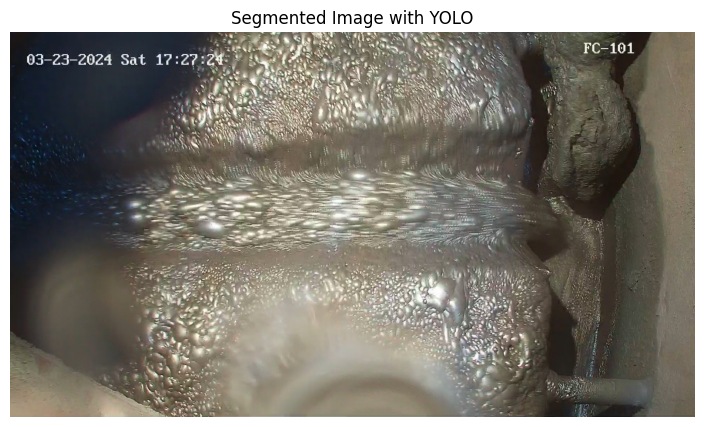

In [37]:
# Визуализация результатов
segmented_image = results[0].plot()  # Получение изображения с наложенными маскам
# Отображение с помощью matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(segmented_image)
plt.axis('off')
plt.title("Segmented Image with YOLO")
plt.show()

In [44]:
model = YOLO("baseline.pt")
results = infer_image("./cv_test_dataset/test_img/_08.jpg")
mask_image = create_mask("./cv_test_dataset/test_img/_08.jpg", results)

# Сохраняем маску в формате PNG
mask_output_path = './mask_image.png'  # Укажите путь для сохранения маски
cv2.imwrite(mask_output_path, mask_image)

FileNotFoundError: [Errno 2] No such file or directory: './cv_test_dataset/test_img/_08.jpg'